**Criando conexão com banco de dados**

In [1]:
!pip install google-cloud-bigquery

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
import os
from google.cloud import bigquery
from google.colab import data_table

project= 'scenic-cedar-403421'
location='US'
client = bigquery.Client(project = project, location = location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

Realizando Web Scrapping

In [217]:
  # Entrando no Site da IPEA
  endereco = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

  # Criando objeto pagina
  resposta = requests.get(endereco)

  # Verifica a resposta do site
  if resposta is not None and resposta.status_code == 200:
      soup = BeautifulSoup(resposta.text, 'html.parser')

      #Procurar a tabela no html
      tabela= soup.find('table', {'id':'grd_DXMainTable'})

      #Le a tabela html e faz as alterações necessarias
      df=pd.read_html(str(tabela), skiprows=0)[0]

      df.columns=df.iloc[0]
      df=df.drop(0)

      #Modificação do tipo de dados das colunas
      df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
      df['Data'] = df['Data'].dt.strftime('%Y-%m-%d') #Altera a data para o formato americado por causa do BigQuery
      df['Preço - petróleo bruto - Brent (FOB)'] = pd.to_numeric(df['Preço - petróleo bruto - Brent (FOB)'])
      df['Preço - petróleo bruto - Brent (FOB)']=df['Preço - petróleo bruto - Brent (FOB)']/100  #Formato float
      df.rename(columns={'Preço - petróleo bruto - Brent (FOB)': 'Preco'}, inplace=True) #Altera nome da coluna por causa do BigQuery
      #Salva os dados em CSV
      df.to_csv('ipea.csv', index=False)

  else:
    print('Falha ao acessar a pagina do IPEA')

Inserindo os dados no Banco de dados

In [218]:
# Consulta para encontrar a data mais recente
query = """
SELECT MAX(Data) AS data_mais_recente
FROM `scenic-cedar-403421.Tech_Challenge4.tbl_ipea`
"""

# Executa a consulta
query_job = client.query(query)
results = query_job.result()

# ExtraÍ a data mais recente
for row in results:
    data_mais_recente = row.data_mais_recente


data_mais_recente_df = df['Data'].max()
data_mais_recente_df = pd.to_datetime(data_mais_recente_df, dayfirst=True)
data_mais_recente = pd.to_datetime(data_mais_recente, dayfirst=True)

#Comapara a data mais recente do banco com a data mais recente do web scrapping
if data_mais_recente_df > data_mais_recente:

    #Se a data do web scrapping for maior, vamos carregar apenas os dados diferentes entre o banco e o html
    df['Data'] = pd.to_datetime(df['Data']).dt.date
    df_novos_dados = df[df['Data'] > data_mais_recente]

    # Salva os dados filtrados em um novo CSV
    df_novos_dados.to_csv('ipea_novos_dados.csv', index=False)

    # Carrega novo CSV para o BigQuery
    caminho = 'ipea_novos_dados.csv'
    table_id = 'scenic-cedar-403421.Tech_Challenge4.tbl_ipea'

    job_config = bigquery.LoadJobConfig(
        source_format=bigquery.SourceFormat.CSV,
        skip_leading_rows=1,
        autodetect=True,
    )

    with open(caminho, "rb") as source_file:
        load_job = client.load_table_from_file(source_file, table_id, job_config=job_config)

    load_job.result()

    table = client.get_table(table_id)
    print(f"Carregado {table.num_rows} linhas na tabela {table_id}.")
else:
    print("Não há dados novos para carregar.")


Não há dados novos para carregar.


Primeiro carregamento dos dados no Banco de Dados

In [6]:
#Inserindo os dados do WebScrapping no Banco de dados (Google Big Query), Só foi usado no primeiro carregamento.

caminho='/content/ipea.csv'
table_id = 'scenic-cedar-403421.Tech_Challenge4.tbl_ipea'

job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True,
)

with open(caminho, "rb") as source_file:
    load_job = client.load_table_from_file(source_file, table_id, job_config=job_config)

load_job.result()

table = client.get_table(table_id)
print(f"Carregado {table.num_rows} linhas na tabela {table_id}.")

Carregado 11092 linhas na tabela scenic-cedar-403421.Tech_Challenge4.tbl_ipea.


# **Criação do Modelo**

In [7]:
!pip install prophet
from prophet import Prophet
import matplotlib.pyplot as plt

In [219]:
# Preparando os dados
df['Data'] = pd.to_datetime(df['Data'])
df.rename(columns={'Data': 'ds', 'Preco': 'y'}, inplace=True)



In [220]:
from sklearn.model_selection import train_test_split

n= int(len(df.index.sort_values(ascending=True))*0.8)
df_teste = df[n:]
df_treino = df[:n]

# Verificação das bases de treino e teste
print(f"Treino: {len(df_treino)} linhas")
print(f"Teste: {len(df_teste)} linhas")


Treino: 8873 linhas
Teste: 2219 linhas


In [221]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8873 entries, 1 to 8873
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      8873 non-null   datetime64[ns]
 1   y       8873 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 138.8 KB


# Criação do Modelo

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_2ldkbz/2oruk6v2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_2ldkbz/zpdmpkc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30781', 'data', 'file=/tmp/tmpi_2ldkbz/2oruk6v2.json', 'init=/tmp/tmpi_2ldkbz/zpdmpkc1.json', 'output', 'file=/tmp/tmpi_2ldkbz/prophet_modeljcg20cl3/prophet_model-20240127190247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


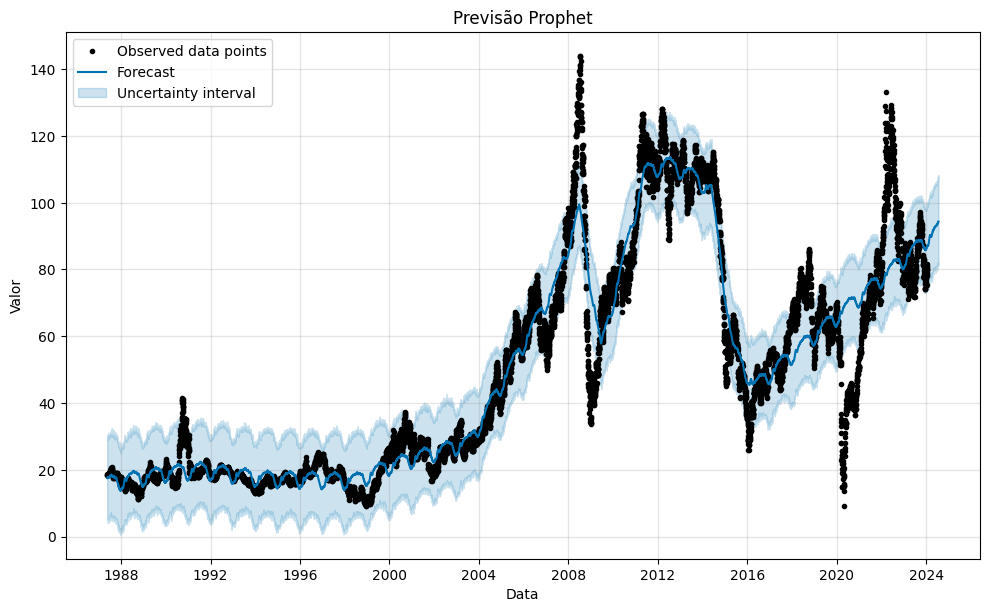

In [222]:
#Utilizando Prophet
# Criação e ajudeste do modelo
model = Prophet(weekly_seasonality=True, daily_seasonality=False)
model.fit(df)

# Gerar datas futuras para os próximos dias
future =model.make_future_dataframe(periods=180)

# datas de segunda(0) a sexta feria (4)
future['day'] = future['ds'].dt.weekday
future = future[future['day'] <= 4]

forecast_prophet = model.predict(future)
fig = model.plot(forecast_prophet)
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Previsão Prophet')
plt.legend()
plt.grid(True)
plt.show()

# Calculando a performance do Modelo

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [223]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Filtrar as previsões para o intervalo do conjunto de teste
previsao_teste = forecast_prophet[forecast_prophet['ds'].isin(df_teste['ds'])]

# Calcular MSE / MAE / RMSE / MAPE
mse = mean_squared_error(df_teste['y'], previsao_teste['yhat'])
mae = mean_absolute_error(df_teste['y'], previsao_teste['yhat'])
RMSE = math.sqrt(mean_squared_error(df_teste['y'], previsao_teste['yhat'].values))
MAPE = np.mean(np.abs(previsao_teste['yhat'].values - df_teste['y'].values) / np.abs(df_teste['y'].values))

print('MAE', mae)  # Mean Absolute Error
print('MSE', mse)  # Erro Quadrático Médio
print('RMSE', RMSE)  # Erro Quadrático Médio da Raiz
print('MAPE', MAPE)  # Erro Percentual Absoluto Médio


MAE 2.557655179197125
MSE 13.999407595408684
RMSE 3.7415782225430867
MAPE 0.13797404738733093


In [224]:
#Calculo do WMAPE
def wmape(y_true, y_pred, weights=None):

    absolute_diff = np.abs(y_true - y_pred)


    if weights is not None:
        weighted_absolute_diff = absolute_diff * weights
    else:
        weighted_absolute_diff = absolute_diff


    if weights is not None:
        weighted_true = y_true * weights
    else:
        weighted_true = y_true

    wmape = (np.sum(weighted_absolute_diff) / np.sum(weighted_true)) * 100

    return wmape


y_true = df_teste['y'].values
y_pred = previsao_teste['yhat']

result_wmape = wmape(y_true, y_pred)
print(f"WMAPE: {result_wmape:.2f}%")

WMAPE: 13.98%


In [225]:
# Formate a coluna 'yhat' como float com duas casas decimais
forecast_prophet['yhat'] = forecast_prophet['yhat'].round(2).astype(float)

# Salve apenas as colunas 'ds' e 'yhat' no arquivo CSV
forecast_prophet[['ds', 'yhat']].to_csv('previsoes.csv', index=False)

In [235]:
#Inserindo os dados da Previsão  no Banco de dados (Google Big Query)

#Primeiro, deleta todas as linhas já existentes da tabela
table_id = 'scenic-cedar-403421.Tech_Challenge4.tbl_previsao'


table_ref = client.dataset('Tech_Challenge4').table('tbl_previsao')

# Monta a consulta SQL DELETE para excluir todas as linhas da tabela
delete_query = f'DELETE FROM `{table_ref.project}.{table_ref.dataset_id}.{table_ref.table_id}` WHERE TRUE'

query_job = client.query(delete_query)
query_job.result()




In [236]:

#Incluí as linhas novas de provisão
caminho='/content/previsoes.csv'

job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True,
)

with open(caminho, "rb") as source_file:
    load_job = client.load_table_from_file(source_file, table_id, job_config=job_config)

load_job.result()

table = client.get_table(table_id)
print(f"Carregado {table.num_rows} linhas na tabela {table_id}.")

Carregado 9524 linhas na tabela scenic-cedar-403421.Tech_Challenge4.tbl_previsao.
